# Processing and integrating 5k PBMCs CITE-seq data

This notebooks provides an example for CITE-seq data processing in Python.

CITE-seq is a method for cellular indexing of transcriptomes and epitopes by sequencing. CITE-seq data is single-cell data comprising transcriptome-wide measurements for each cell (gene expression) as well as surface protein level information, typically for a few dozens of proteins. The method is described in [Stoeckius et al., 2017](https://www.nature.com/articles/nmeth.4380) and also [on the cite-seq.com website](https://cite-seq.com/).

The data used in this notebook is on peripheral blood mononuclear cells (PBMCs) and [has been provided by 10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3).

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../")

## Download data

[The data is available here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3).
Both filtered and raw matrices are required for this notebook.

In [2]:
# This is the directory where those files are downloaded to
data_dir = "data/pbmc5k_protein"

In [3]:
for file in os.listdir(data_dir):
    print(file)

filtered_feature_bc_matrix
raw_feature_bc_matrix
5k_pbmc_protein_v3_raw_feature_bc_matrix.tar.gz
5k_pbmc_protein_v3_filtered_feature_bc_matrix.tar.gz


## Load libraries and data

Import libraries:

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

In [5]:
import muon as mu
from muon import prot as pt

First, we will load filtered matrices that contain counts for cell but not empty droplets. These cells will be used for the downstream analysis.

In [6]:
mdata = mu.read_10x_mtx(os.path.join(data_dir, "filtered_feature_bc_matrix"))

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Next, we will also load count matrices for all the droplets, whether containing cells or empty.

In [7]:
mdata_raw = mu.read_10x_mtx(os.path.join(data_dir, "raw_feature_bc_matrix"))

## Protein

In [8]:
prot = mdata.mod['prot']
prot

AnnData object with n_obs × n_vars = 5247 × 32
    var: 'gene_ids', 'feature_types'

### DSB normalisation

This normalisation method developed for CITE-seq data uses background droplets defined by low RNA content in order to estimate background protein signal and remove it from the data. [More details and its original implementation are available in the `dsb` GitHub repository](https://github.com/niaid/dsb).

`muon` brings `dsb` normalisation method to Python CITE-seq workflows. 

```py
pt.pp.dsb(mdata, raw=mdata_raw, empty_droplets=droplets)
```

Please note due to the nature of the `dsb` method it behaves in a slightly different way than many other preprocessing and normalisation methods. Its implementation in `muon` offers 2 ways to use the method.

1. Operate on 2 AnnData / MuData objects — filtered and raw. Cell calling from the filtered data is used to define cells in the raw data then.

1. As in the original implementation, operate on raw matrices and then return a copy of the data where only specified cells are kept.

Here, we use the first way of using the method. We would still need to calculate `log10umi` value for each droplet to define which droplets are empty.

In [9]:
mdata_raw['rna'].obs["log10umi"] = np.array(np.log10(mdata_raw['rna'].X.sum(axis=1) + 1)).reshape(-1)

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


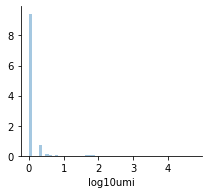

In [10]:
mu.pl.histogram(mdata_raw['rna'], ['log10umi'], bins=50)

For clarity, let's zoom into the part of this data:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


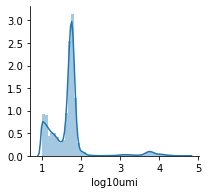

In [11]:
mu.pl.histogram(mdata_raw['rna'][mdata_raw['rna'].obs.log10umi >= 1], ['log10umi'], bins=50)

In this dataset, isotype antibody controls are available that also can be taken into account by the normalisation method:

In [12]:
isotypes = mdata_raw['prot'].var_names[29:32].values
isotypes

array(['IgG1_control_TotalSeqB', 'IgG2a_control_TotalSeqB',
       'IgG2b_control_TotalSeqB'], dtype=object)

Preserve original counts in a layer before the normalisation:

In [13]:
prot.layers['counts'] = prot.X

Normalise counts in `mdata`:

In [14]:
pt.pp.dsb(mdata, mdata_raw, empty_counts_range=(1.5, 2.8), isotype_controls=isotypes, random_state=1)

/Users/bredikhi/git/compbio/muon/muon/_prot/preproc.py:129: UserWarning: Dropping 49 empty droplets as they are already defined as cells
  warn(
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Plot values to visualise the effect of normalisation:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


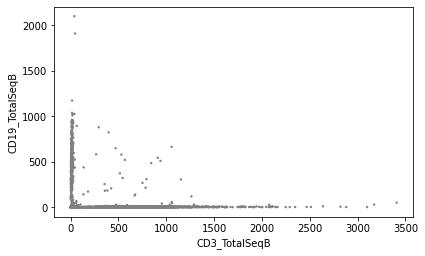

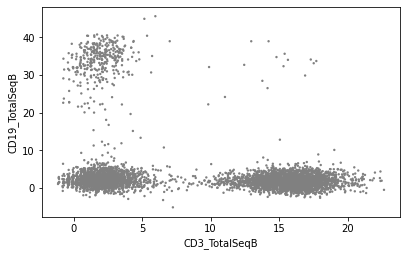

In [15]:
sc.pl.scatter(mdata['prot'], x="CD3_TotalSeqB", y="CD19_TotalSeqB", layers='counts')
sc.pl.scatter(mdata['prot'], x="CD3_TotalSeqB", y="CD19_TotalSeqB")

### Downstream analysis

We can run conventional methods like PCA on the normalised protein counts:

In [18]:
sc.tl.pca(prot)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


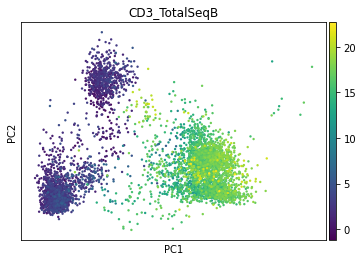

In [19]:
sc.pl.pca(prot, color='CD3_TotalSeqB')

In [20]:
sc.pp.neighbors(prot)
sc.tl.umap(prot, random_state=1)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


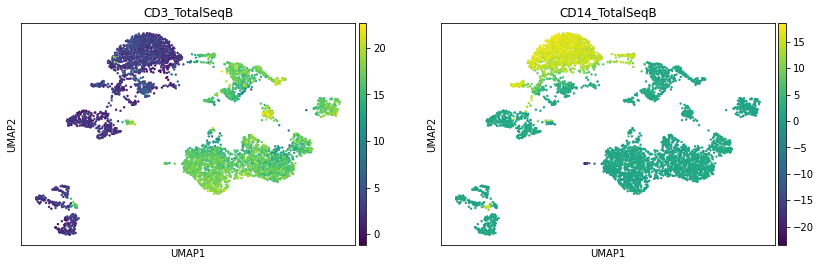

In [21]:
sc.pl.umap(prot, color=['CD3_TotalSeqB', 'CD14_TotalSeqB'])

## RNA

In [22]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 5247 × 33538
    var: 'gene_ids', 'feature_types'

### QC

Perform some quality control. For now, we will filter out cells that do not pass QC.

In [23]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


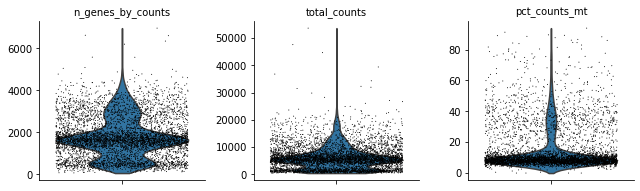

In [24]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Filter genes which expression is not detected:

In [25]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# Same as the following but doesn't copy the object:
#   sc.pp.filter_genes(rna, min_cells=3)

Filter cells:

In [26]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# Same as the following but doesn't copy the object
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]

mu.pp.filter_obs(rna, 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

Let's see how the data looks after filtering:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


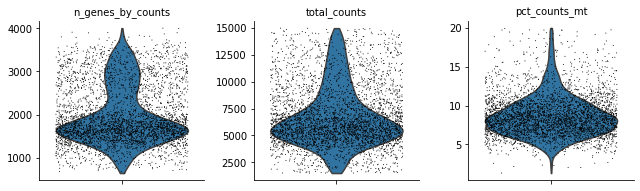

In [27]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

#### Normalisation

We'll normalise the data so that we get log-normalised counts to work with.

In [28]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [29]:
sc.pp.log1p(rna)

#### Feature selection

We will label highly variable genes that we'll use for downstream analysis.

In [30]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

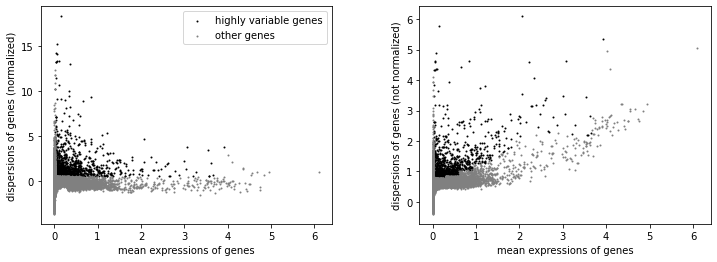

In [31]:
sc.pl.highly_variable_genes(rna)

In [32]:
np.sum(rna.var.highly_variable)

1734

#### Scaling

We'll save log-normalised counts in a `.raw` slot:

In [33]:
rna.raw = rna

... and scale the log-normalised counts to zero mean and unit variance:

In [34]:
sc.pp.scale(rna, max_value=10)

### Analysis

Having filtered low-quality cells, normalised the counts matrix, and performed feature selection, we can already use this data for multimodal integration.

However it is usually a good idea to study individual modalities as well.
Below we run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types.

#### PCA and neighbourhood graph

In [35]:
sc.tl.pca(rna, svd_solver='arpack')

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


To visualise the result, we will use some markers for (large-scale) cell populations we expect to see such as T cells and NK cells (CD2), B cells (CD79A), and KLF4 (monocytes).

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


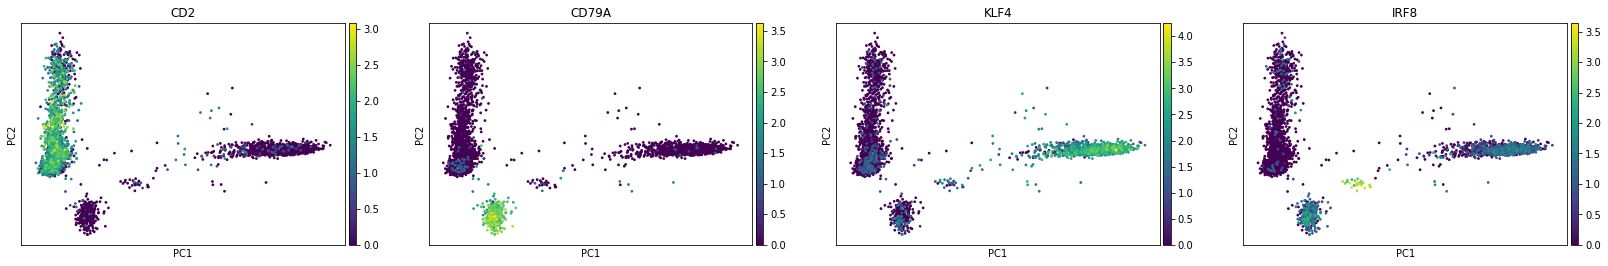

In [36]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

The first principal component (PC1) is separating myeloid (monocytes) and lymphoid (T, B, NK) cells while B cells-related features seem to drive the second one. Also we see plasmocytoid dendritic cells (marked by IRF8) being close to B cells along the PC2.

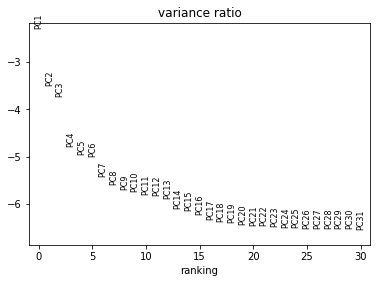

In [37]:
sc.pl.pca_variance_ratio(rna, log=True)

Now we can compute a neighbourhood graph for cells:

In [38]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

#### Non-linear dimensionality reduction and clustering

With the neighbourhood graph computed, we can now perform clustering. We will use `leiden` clustering as an example.

In [39]:
sc.tl.leiden(rna, resolution=.75)

To visualise the results, we'll first generate a 2D latent space with cells that we can colour according to their cluster assignment.

In [40]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


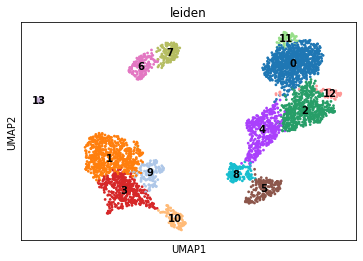

In [41]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

#### Cell type annotation

In [42]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test_overestim_var')

In [43]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p
0,RPL32,1.380112e-247,S100A8,0.000000e+00,IL7R,4.827268e-175,CST3,8.457789e-138,CCL5,1.614990e-191,GNLY,1.868870e-151,CD79A,6.409675e-113,IGHM,1.284390e-142,GNLY,2.305955e-92,TYMP,4.113971e-44,FCGR3A,7.931312e-73,CD8B,1.344611e-28,IL32,5.583487e-09,ITM2C,1.106098e-36
1,RPS3A,1.627373e-256,S100A9,4.101797e-317,LTB,1.387967e-107,CPVL,4.945355e-162,NKG7,2.032769e-140,NKG7,5.122287e-96,MS4A1,1.513867e-103,CD79A,6.570059e-124,FGFBP2,1.190382e-102,LYZ,5.675880e-35,LST1,3.169949e-44,CD8A,1.179723e-20,TIGIT,7.622707e-07,CCDC50,3.365550e-34
2,RPL30,9.687924e-237,VCAN,3.394343e-312,IL32,2.100285e-104,LYZ,2.891312e-127,GZMA,1.524691e-106,KLRD1,4.177880e-111,HLA-DQA1,3.751459e-106,CD79B,2.500853e-106,GZMH,7.659337e-98,FCN1,4.341500e-35,TCF7L2,1.098160e-45,RPS3A,3.524939e-13,PBXIP1,6.263715e-07,IL3RA,2.391788e-23
3,RPL13,2.673413e-227,LYZ,1.467838e-237,TRAC,7.044805e-82,FCN1,3.664234e-123,CST7,2.410078e-106,KLRF1,2.123803e-102,BANK1,1.331708e-84,IGHD,9.719686e-72,PRF1,1.626375e-91,XAF1,7.801962e-43,SMIM25,3.171766e-49,LINC02446,7.812095e-13,IKZF2,1.872429e-06,PLD4,1.246058e-27
4,RPL11,5.299188e-232,MNDA,1.131567e-278,CD2,2.779068e-67,FGL2,1.029085e-127,IL32,2.124480e-90,PRF1,1.035347e-103,CD79B,7.403563e-79,MS4A1,5.945622e-89,KLRC2,3.624602e-75,FGL2,1.961404e-38,LYN,1.090891e-46,RPS2,1.307254e-12,TRBC2,1.364242e-06,IRF8,2.272772e-29
5,RPS12,2.484028e-223,S100A12,3.040667e-307,AQP3,1.363019e-56,KLF4,5.745357e-131,GZMM,3.587211e-83,CTSW,2.070524e-100,HLA-DQB1,6.762216e-69,TCL1A,5.585904e-65,NKG7,5.237177e-70,CST3,3.191349e-34,MS4A7,6.730315e-51,RPS6,1.514270e-12,DUSP4,4.791963e-06,TCF4,2.379937e-28
6,RPS6,1.943468e-227,FCN1,3.913932e-244,CD3E,4.321252e-53,AIF1,3.486286e-117,KLRG1,1.147997e-74,GZMA,8.167419e-91,CD37,1.360556e-57,HLA-DQA1,1.723135e-87,CST7,5.730287e-82,CTSS,1.003140e-33,CDKN1C,2.347009e-39,RPL13,1.869602e-12,HACD1,1.189909e-05,UGCG,2.010952e-26
7,RPL9,3.701542e-226,CD14,5.684490e-266,KLRB1,8.857507e-50,HLA-DRA,1.229331e-117,CD3D,3.637893e-73,GZMB,2.485553e-88,RALGPS2,1.241454e-54,CD37,6.685736e-66,GZMB,1.041564e-90,MNDA,1.065729e-35,FCER1G,4.274695e-38,RPS12,2.277374e-12,IL2RA,1.689073e-05,IRF7,3.697920e-27
8,TPT1,4.096112e-227,CTSS,1.729932e-207,RPS18,1.695589e-47,PSAP,1.832311e-117,B2M,7.472893e-70,CLIC3,3.298338e-75,HLA-DPB1,4.220414e-51,HLA-DPB1,4.708672e-47,CCL5,2.700983e-64,PSAP,1.983579e-33,LRRC25,3.008410e-45,RPL32,4.908655e-12,FOXP3,2.616250e-05,JCHAIN,2.922103e-22
9,RPL34,4.347625e-218,CSF3R,9.101933e-243,SPOCK2,6.018993e-48,HLA-DRB1,1.410033e-114,GZMK,1.345830e-53,HOPX,2.743326e-83,HLA-DRA,2.174338e-45,CD74,2.262129e-43,FCGR3A,3.320130e-76,CPVL,3.518379e-38,CFD,5.047007e-41,RPL28,4.009718e-12,TRAC,1.275863e-05,MZB1,4.527073e-20


In [44]:
new_cluster_names = {
    "0": "CD4+ naïve T", "12": "Treg", "2": "CD4+ memory T",
    "11": "CD8+ naïve T", "4": "CD8+ memory T", 
    "5": "NK", "8": "memory-like NK",
    "6": "mature B", "7": "pre-B",
    "1": "CD14 mono", "3": "intermediate mono", "9": "intermediate mono", "10": "CD16 mono",
    "13": "pDC",
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.replace(new_cluster_names)
rna.obs.celltype = rna.obs.celltype.astype("category")

We will also re-order categories for the next plots:

In [45]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'Treg',
    'CD8+ naïve T', 'CD8+ memory T', 'NK', 'memory-like NK',
    'pre-B', 'mature B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'pDC'], inplace=True)

mdata.update()

... and take colours from a palette:

In [46]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


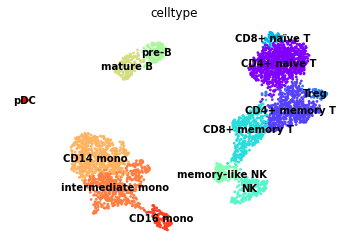

In [47]:
sc.pl.umap(rna, color="celltype", legend_loc="on data", frameon=False)

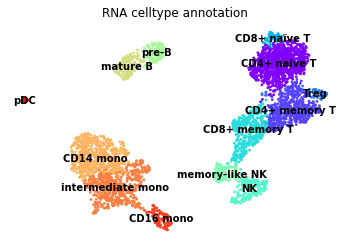

In [48]:
sc.pl.umap(rna, color="celltype", legend_loc="on data", frameon=False,
          title="RNA celltype annotation")

Finally, we'll visualise some marker genes across cell types.

In [49]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'FOXP3', 'IL2RA',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7', 'KLRC2',
                'CD79A', 'MS4A1', 'TCL1A', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b 
                'CD14', 'FCGR3A', 'MS4A7', 
                'CST3', 'IRF8', 'TCF4']

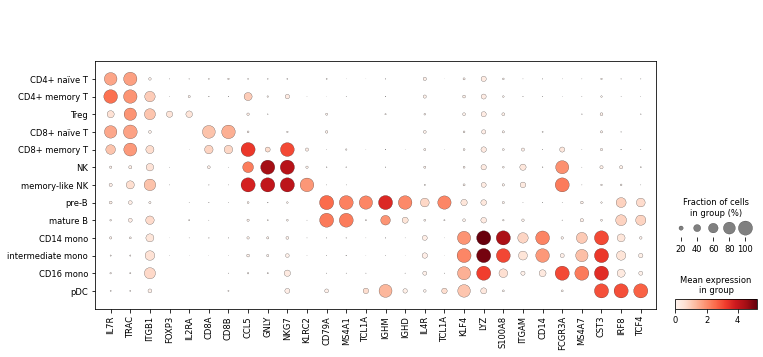

In [50]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

## Plotting

With `mu.pl.embedding` interface we can display an embedding from an individual modality (e.g. `'rna'`) and colour cells by a feature (variable) from another modality.

While variables names should be unique across all modalities, all individual modalities as well as the `mdata` object itself can have e.g. UMAP basis computed. To point to a basis from a specific modality, use `mod:basis` syntax, e.g. with `"rna:X_umap"` in the example below `mdata.mod['rna'].obsm["X_umap"]` basis is going to be used. 

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


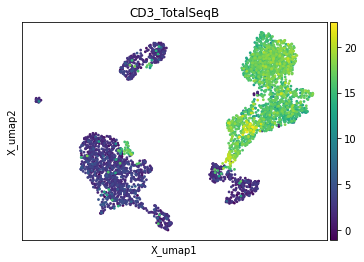

In [51]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD3_TotalSeqB"])

## Multi-omics integration

Having filtered cells at the RNA QC step, we will now subset them in the protein modality as well so that we can work with the union of cells:

In [52]:
mu.pp.intersect_obs(mdata)

### Multiplex clustering

We can run clustering based on neighbours information from each modality taking advantage of multiplex versions of algorithms such as `leiden` or `louvain`.

In [53]:
mu.tl.louvain(mdata, resolution=[2, .1], random_state=1)

In [54]:
mu.tl.leiden(mdata, resolution=[2, .1], random_state=1)

In [55]:
mdata.uns['louvain']

{'params': {'resolution': [2, 0.1],
  'random_state': 1,
  'partition_improvement': 91323.3393340929}}

In [56]:
mdata.uns['leiden']

{'params': {'resolution': [2, 0.1],
  'random_state': 1,
  'partition_improvement': 91166.75577710925}}

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


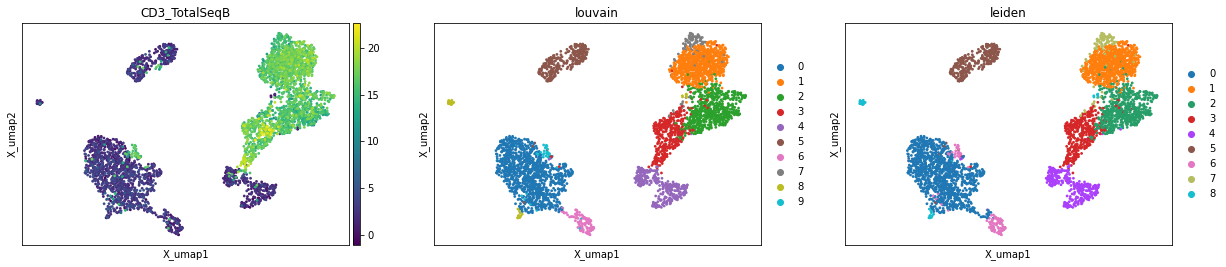

In [57]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD3_TotalSeqB", "louvain", "leiden"])

### Multi-omics factor analysis

To generate an interpretable latent space for both `'rna'` and `'prot'` modalities we will now run **multi-omic factor analysis** — a group factor analysis method that will allow us to learn an interpretable latent space jointly on both modalities. Intuitively, it can be viewed as a generalisation of PCA for multi-omics data. More information about this method can be found [on the MOFA website](https://biofam.github.io/MOFA2/).

In [58]:
prot.var["highly_variable"] = True
mdata.update()

In [21]:
mu.tl.mofa(mdata, outfile="models/pbmc5k_citeseq.hdf5",
           n_factors=30)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='prot' group='group1' with N=3891 samples and D=32 features...
Loaded view='rna' group='group1' with N=3891 samples and D=1734 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: Tru

In [62]:
# # NOTE: if you wish to load the trained model,
# #       use mofax library to quickly add 
# #       factors and weights matrices 
# #       to the mdata object
# # 
# import mofax as mfx
# model = mfx.mofa_model('models/pbmc5k_citeseq_v2.hdf5')
# mdata.obsm["X_mofa"] = model.get_factors()

# # If only highly variable features were used
# w = model.get_weights()
# # Set the weights of features that were not used to zero
# mdata.varm["LFs"] = np.zeros(shape=(mdata.n_vars, w.shape[1]))
# mdata.varm["LFs"][mdata.var["highly_variable"]] = w

# model.close()

... storing 'rna:leiden' as categorical
... storing 'rna:celltype' as categorical
... storing 'louvain' as categorical
... storing 'leiden' as categorical


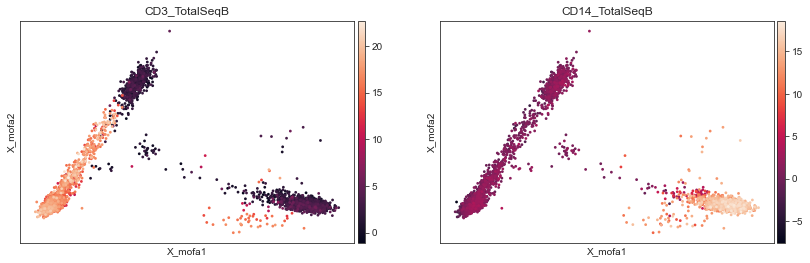

In [63]:
mu.pl.mofa(mdata, color=['CD3_TotalSeqB', 'CD14_TotalSeqB'])

In [64]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

In [65]:
mdata.uns["rna:celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

... storing 'louvain' as categorical
... storing 'leiden' as categorical


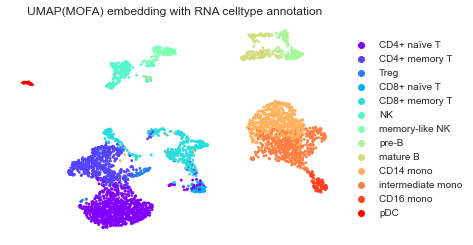

In [73]:
mu.pl.umap(mdata, color=['rna:celltype'], frameon=False,
           title="UMAP(MOFA) embedding with RNA celltype annotation")

... storing 'louvain' as categorical
... storing 'leiden' as categorical


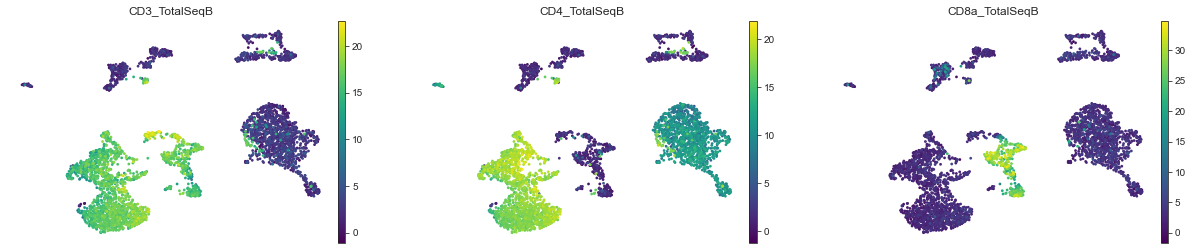

In [74]:
mu.pl.umap(mdata, color=['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB'], frameon=False, cmap='viridis')

Proteins highlighting the memory — naïve axis will also help to refine memory/naïve T cells annotation:

... storing 'louvain' as categorical
... storing 'leiden' as categorical


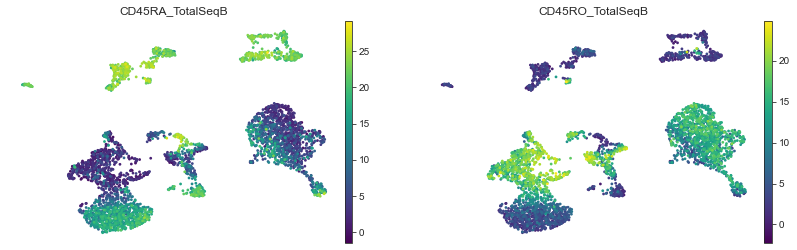

In [75]:
mu.pl.umap(mdata, color=['CD45RA_TotalSeqB', 'CD45RO_TotalSeqB'], frameon=False, cmap='viridis')

... storing 'louvain' as categorical
... storing 'leiden' as categorical


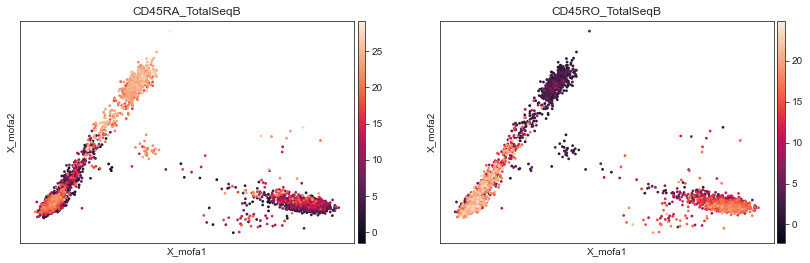

In [76]:
mu.pl.mofa(mdata, color=['CD45RA_TotalSeqB', 'CD45RO_TotalSeqB'])

### Interpreting the model

In [80]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 150

In [78]:
import mofax as mofa
model = mofa.mofa_model("models/pbmc5k_citeseq.hdf5")

<AxesSubplot:title={'center':'rna'}, xlabel='Feature weight'>

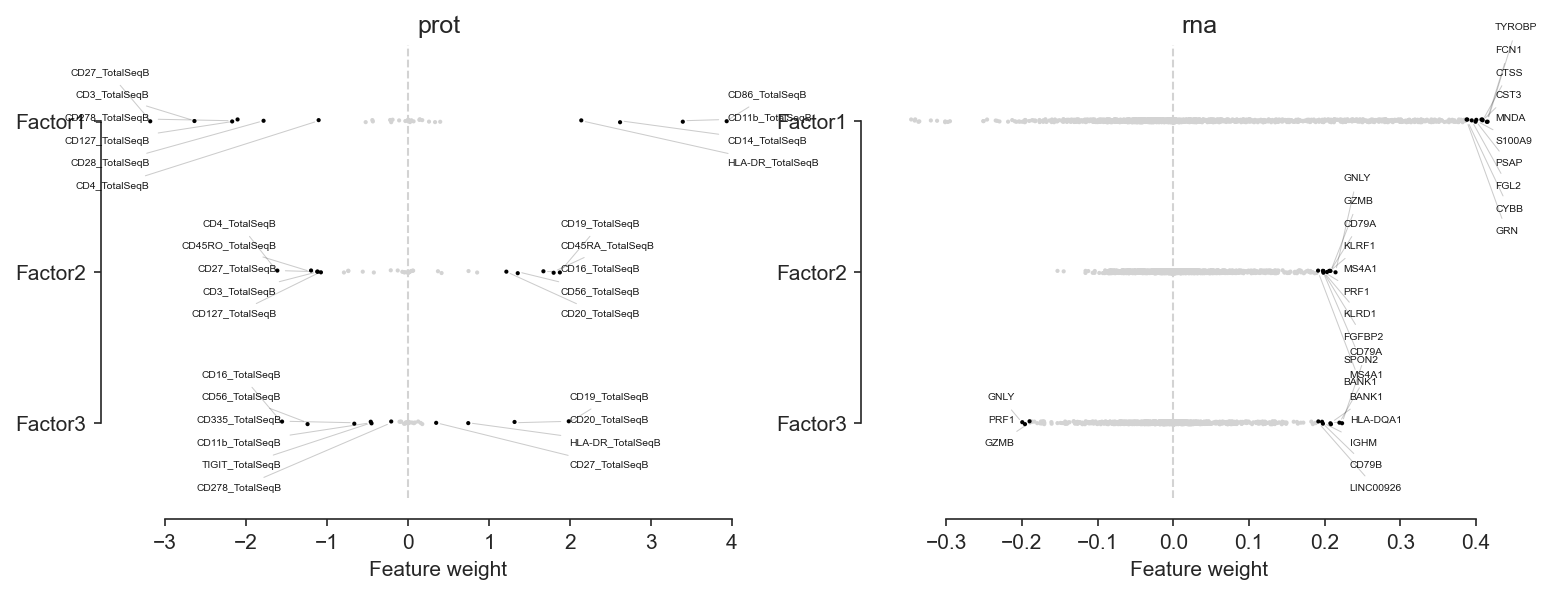

In [81]:
mofa.plot_weights(model, factors=range(3), n_features=10, sharex=False)

While `Factor1` corresponds to lymphoid — myeloid axis, `Factor2` seems to highlight T — B & NK axis and, at least partly, memory — naïve variability: `CD45RO` and `CD127` are memory markers while `CD45RA` is a naïveté marker.

In [84]:
model.metadata["rna:celltype"] = model.metadata["rna:celltype"].astype('category').cat.reorder_categories(mdata['rna'].obs.celltype.cat.categories)

<AxesSubplot:ylabel='Factor value'>

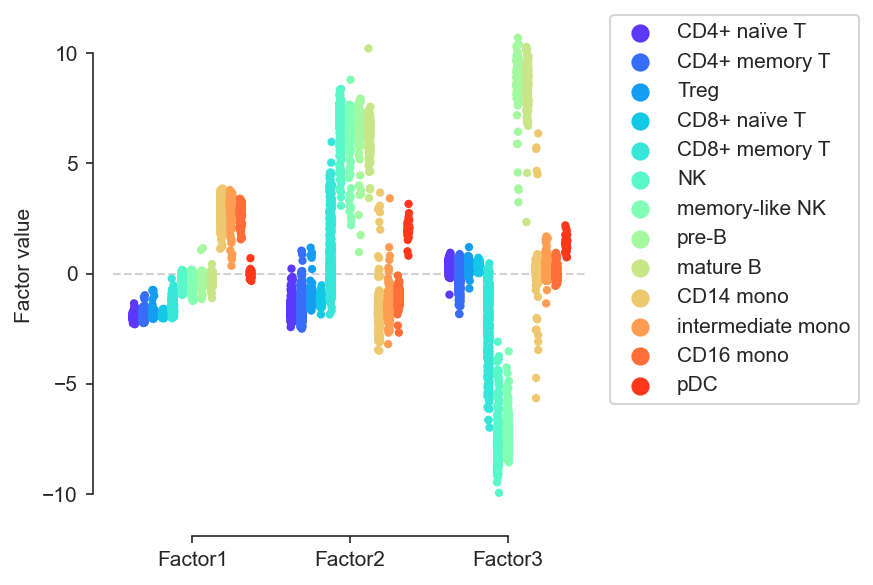

In [85]:
mofa.plot_factors_violin(model, color='rna:celltype', factors=range(3), dots=True, violins=False, palette='rainbow')

<AxesSubplot:title={'center':'CD19_TotalSeqB'}, xlabel='Factor2 value', ylabel='Factor3 value'>

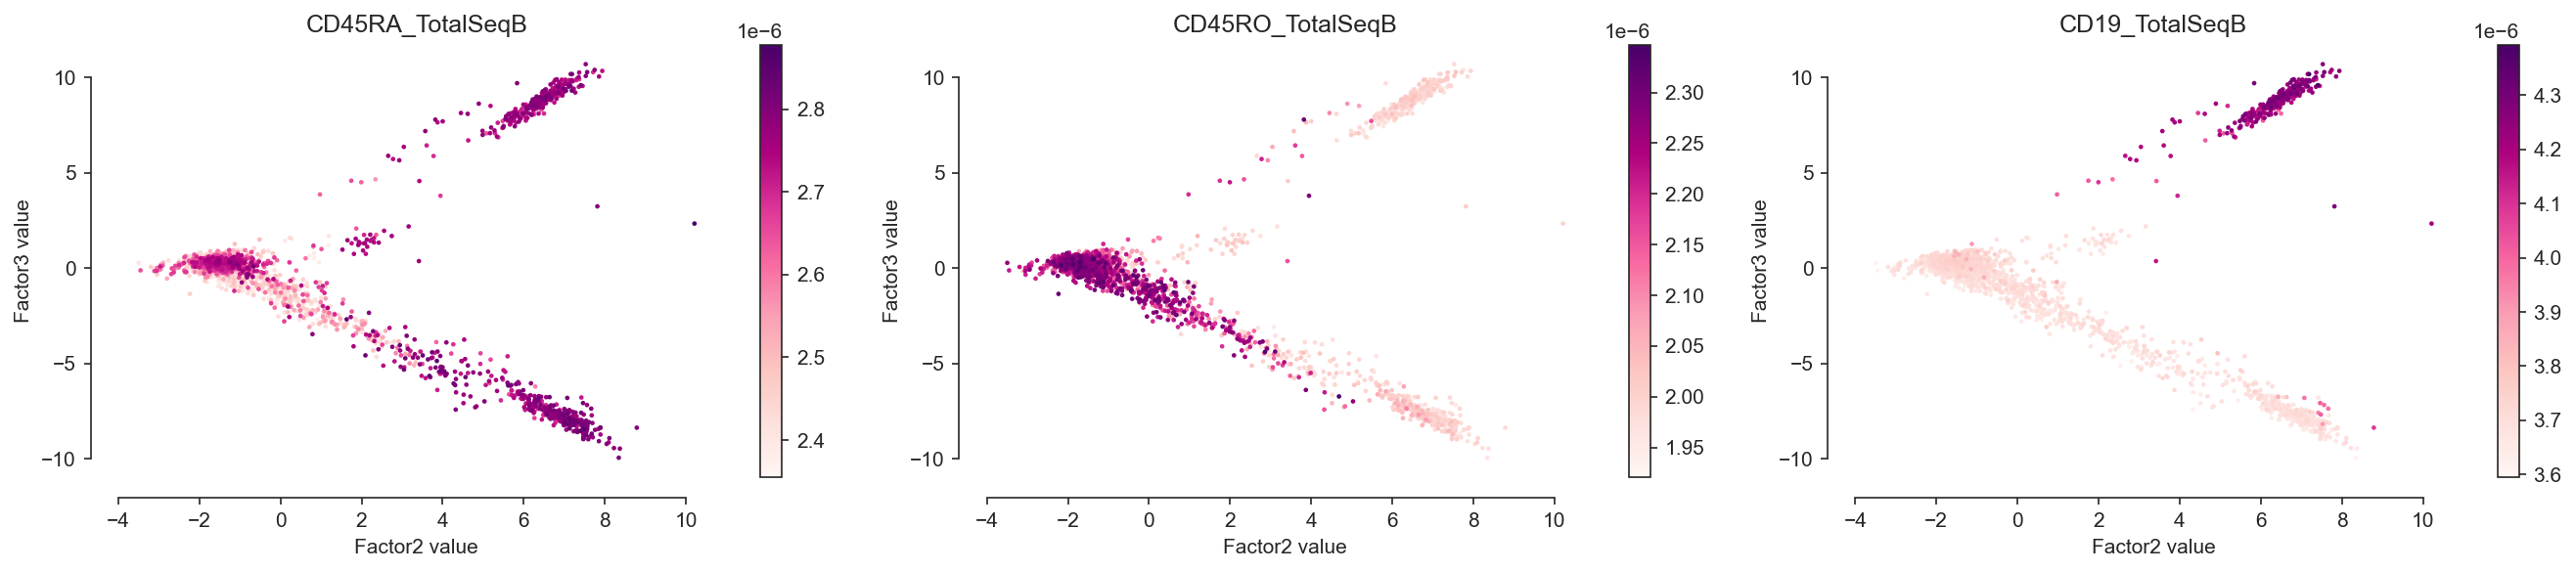

In [90]:
mofa.plot_factors(model, x=1, y=2, color=["CD45RA_TotalSeqB", "CD45RO_TotalSeqB", "CD19_TotalSeqB"], palette="RdPu")

<AxesSubplot:title={'center':'CD16_TotalSeqB'}, xlabel='Factor1 value', ylabel='Factor2 value'>

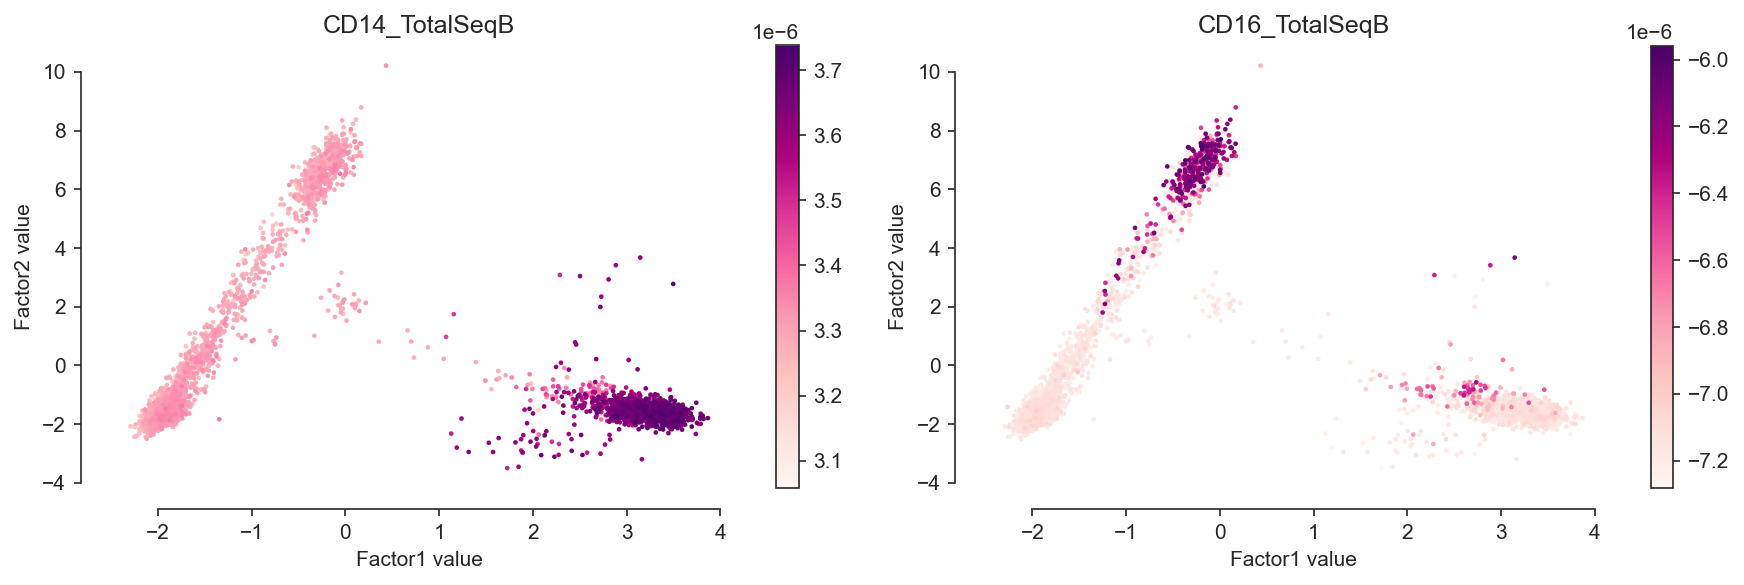

In [91]:
mfx.plot_factors(model, color=["CD14_TotalSeqB", "CD16_TotalSeqB"], palette="RdPu")

In [95]:
model.close()

## Saving multimodal data on disk

We will now write `mdata` object to an `.h5mu` file.

In [96]:
mdata.write("data/pbmc5k_citeseq.h5mu")

... storing 'louvain' as categorical
... storing 'leiden' as categorical
... storing 'feature_types' as categorical
